In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import jax
import jaxopt
import jax.numpy as jnp
import jax.scipy.optimize
import scipy.optimize as optimize
jax.config.update("jax_enable_x64", True)

## Parabolic minimization 

Parabolic minimization makes an approximation of the function as a parabola, based on three points, and steps to the minimum of that function.

In [2]:
def parabolic_step(func=None, a=None, b=None, c=None):
    """returns the minimum of the function as approximated by a parabola"""
    fa = func(a)
    fb = func(b)
    fc = func(c)
    denom = (b - a) * (fb - fc) - (b -c) * (fb - fa)
    numer = (b - a)**2 * (fb - fc) - (b -c)**2 * (fb - fa)
    # If singular, just return b 
    if(np.abs(denom) < 1.e-15):
        x = b
    else:
        x = b - 0.5 * numer / denom
    return(x)

Let us try this on a parabola.

In [4]:
def func_parabola(x):
    return((x - 1.1)**2)

<IPython.core.display.Javascript object>


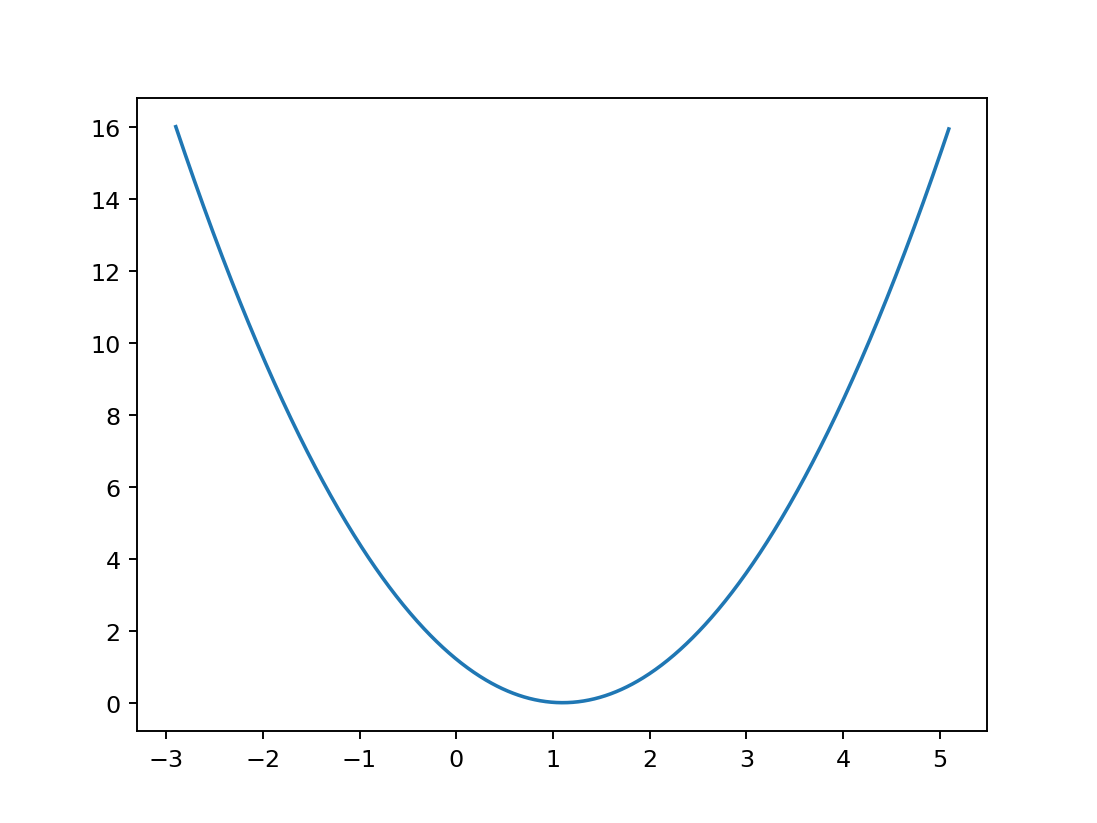

In [5]:
xgrid = -4. + 8. * np.arange(1000) / 1000. + 1.1
plt.plot(xgrid, func_parabola(xgrid))

In [6]:
a = 2.
b = 3.
c = 4.
print(parabolic_step(func=func_parabola, a=a, b=b, c=c))

1.1000000000000008


Now let's try iterating this on a non-parabolic function, which is nevertheless convex.

In [7]:
def parabolic_minimize(func=None, astart=None, bstart=None, cstart=None,
                       tol=1.e-5, maxiter=10000):
    xgrid = -12. + 25. * np.arange(10000) / 10000. 
    plt.plot(xgrid, func(xgrid))
    a = astart
    b = bstart
    c = cstart
    bold = b + 2. * tol
    niter = 0
    while((np.abs(bold - b) > tol) & (niter < maxiter)):
        bold = b
        b = parabolic_step(func=func, a=a, b=b, c=c)
        if(b < bold):
            c = bold
        else:
            a = bold
        step = np.array([bold, b])
        plt.plot(step, func(step), color='black')
        plt.plot(step, func(step), '.', color='black')
        niter = niter + 1
    return(b)

In [8]:
def func_test(x):
    dx = x - 0.6
    return(0.1 * dx**4 - 0.5 * dx**3 + dx**2 + 2. * dx)

<IPython.core.display.Javascript object>


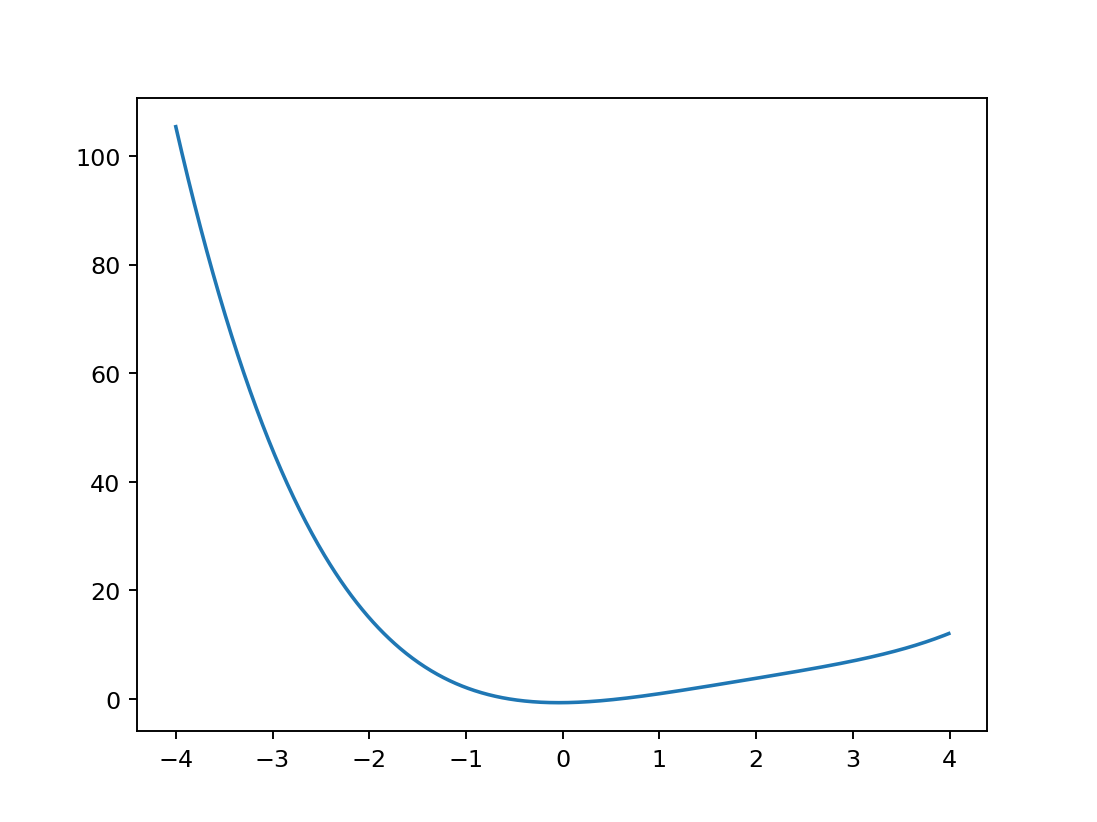

In [9]:
xgrid = -4. + 8. * np.arange(1000) / 1000. 
plt.plot(xgrid, func_test(xgrid))

<IPython.core.display.Javascript object>


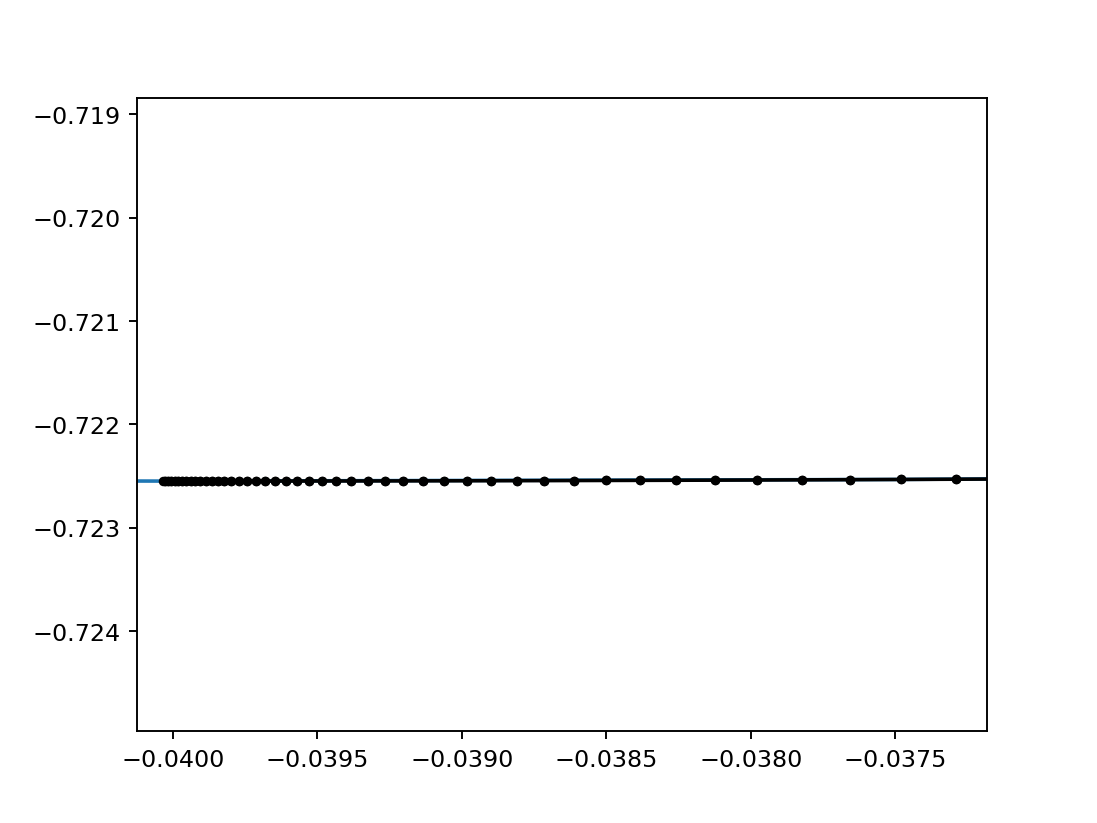

-0.04003502515313969

In [10]:
parabolic_minimize(func=func_test, astart=1., bstart=2., cstart=3.)

Now let's try a non-convex function.

In [12]:
def func_test2(x):
    dx = x - 0.6
    return(0.0003 * dx**4 - 0.03 * dx**2)

<IPython.core.display.Javascript object>


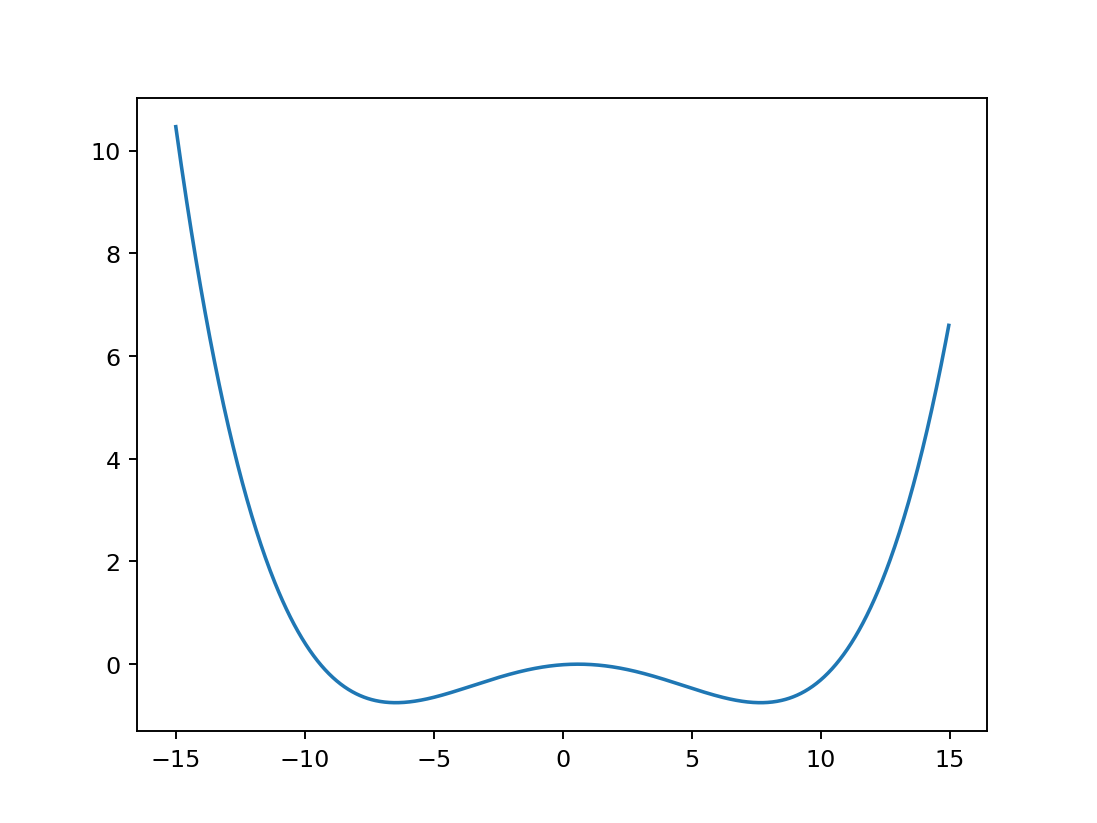

In [13]:
xgrid = -15. + 30. * np.arange(1000) / 1000. 
plt.plot(xgrid, func_test2(xgrid))

Note that this method does not distinguish between maximum and minimum!

<IPython.core.display.Javascript object>


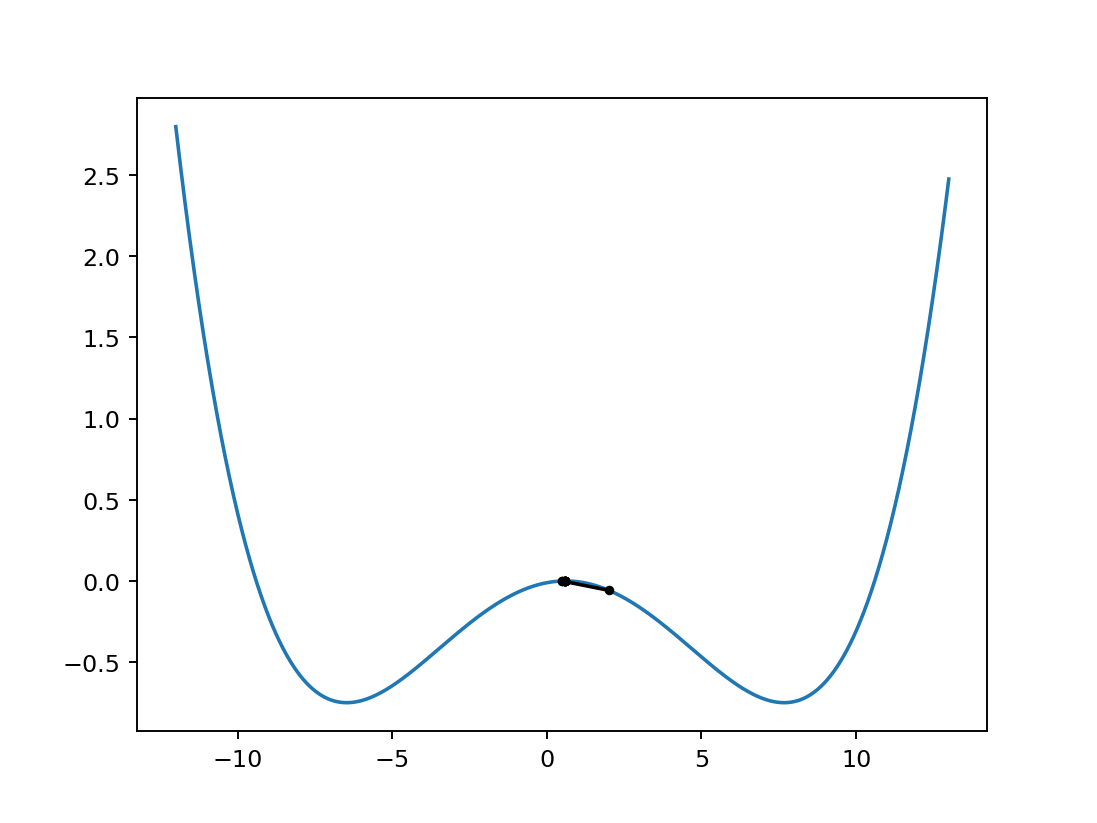

0.599999999998569

In [14]:
parabolic_minimize(func=func_test2, astart=1., bstart=2., cstart=3.)

It will find one minimum just fine.

<IPython.core.display.Javascript object>


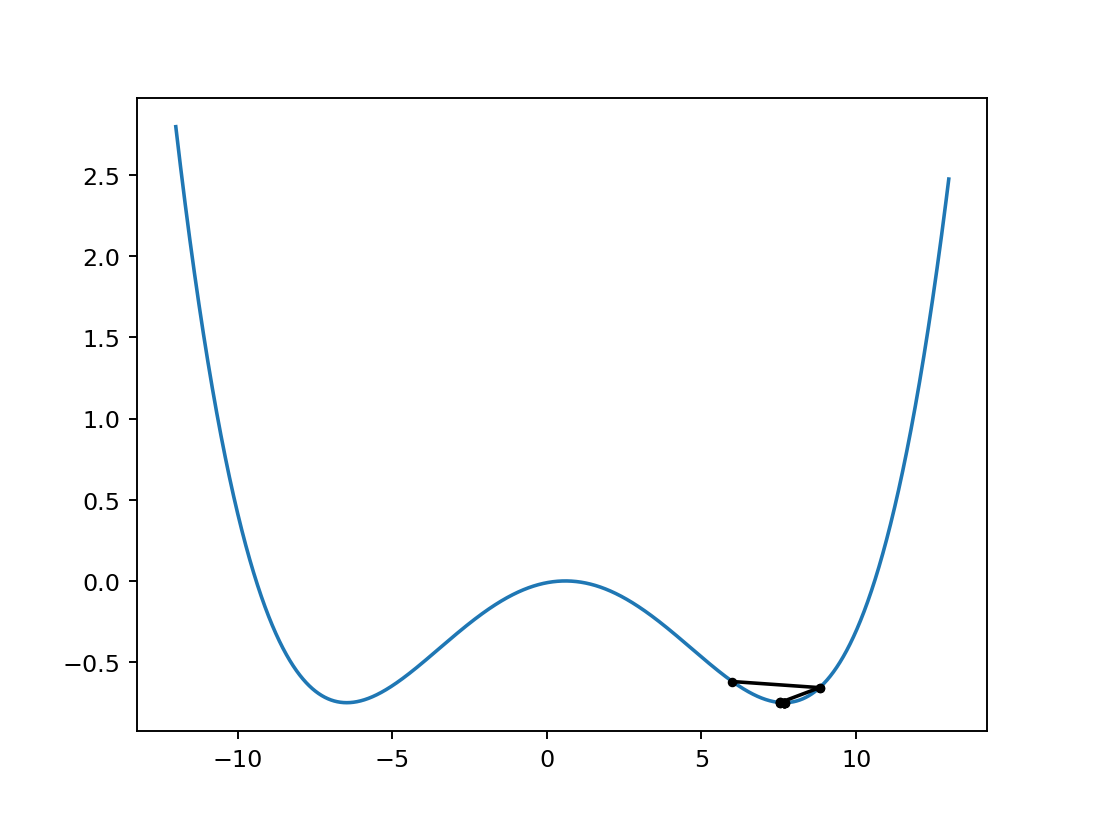

7.671067797053526

In [15]:
parabolic_minimize(func=func_test2, astart=5., bstart=6., cstart=7.)

What happens if we bracket both?

<IPython.core.display.Javascript object>


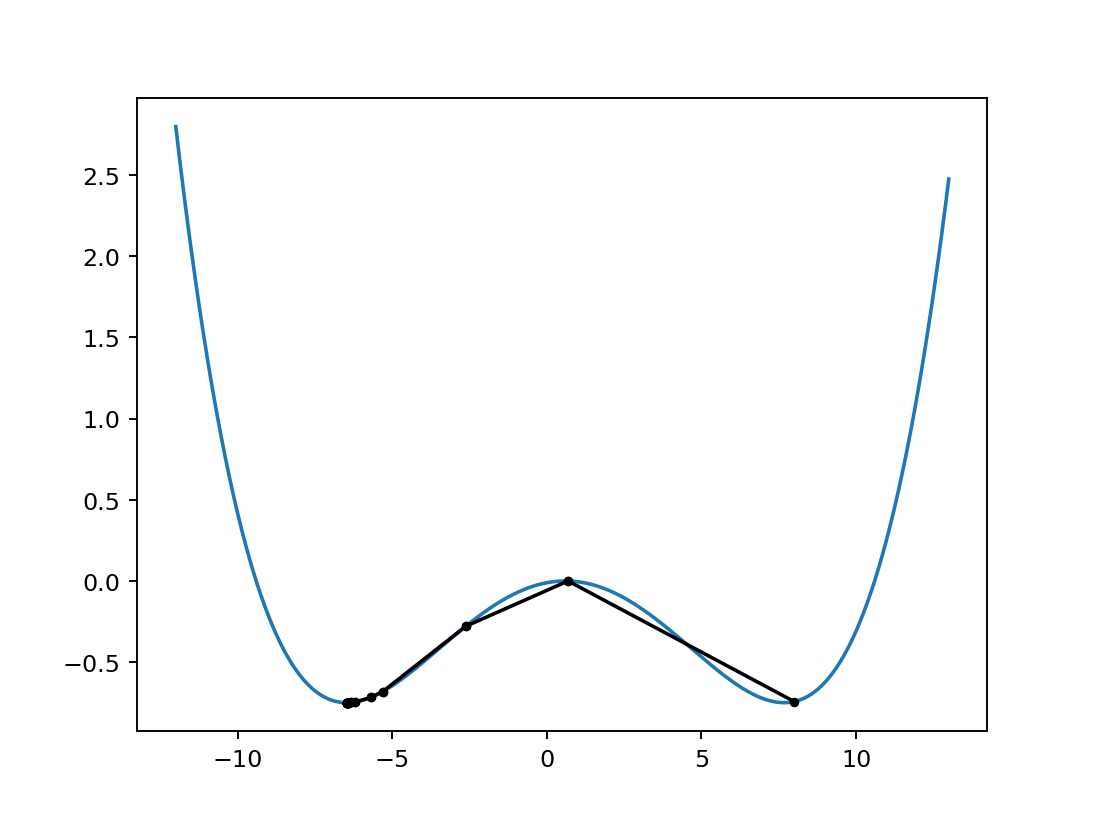

-6.471063467886177

In [16]:
parabolic_minimize(func=func_test2, astart=-9., bstart=8., cstart=10.)

## Golden section search

In [17]:
def golden(func=None, astart=None, bstart=None, cstart=None, tol=1.e-5):
    xgrid = -12. + 25. * np.arange(10000) / 10000. 
    plt.plot(xgrid, func(xgrid))
    gsection = (3. - np.sqrt(5)) / 2
    a = astart
    b = bstart
    c = cstart
    while(np.abs(c - a) > tol):
        # Split the larger interval
        if((b - a) > (c - b)):
            x = b
            b = b - gsection * (b - a)
        else:
            x = b + gsection * (c - b)
        step = np.array([b, x])
        plt.plot(step, func(step), color='black')
        plt.plot(step, func(step), '.', color='black')
        fb = func(b)
        fx = func(x)
        if(fb < fx):
            c = x
        else:
            a = b
            b = x 
    print(b)

<IPython.core.display.Javascript object>


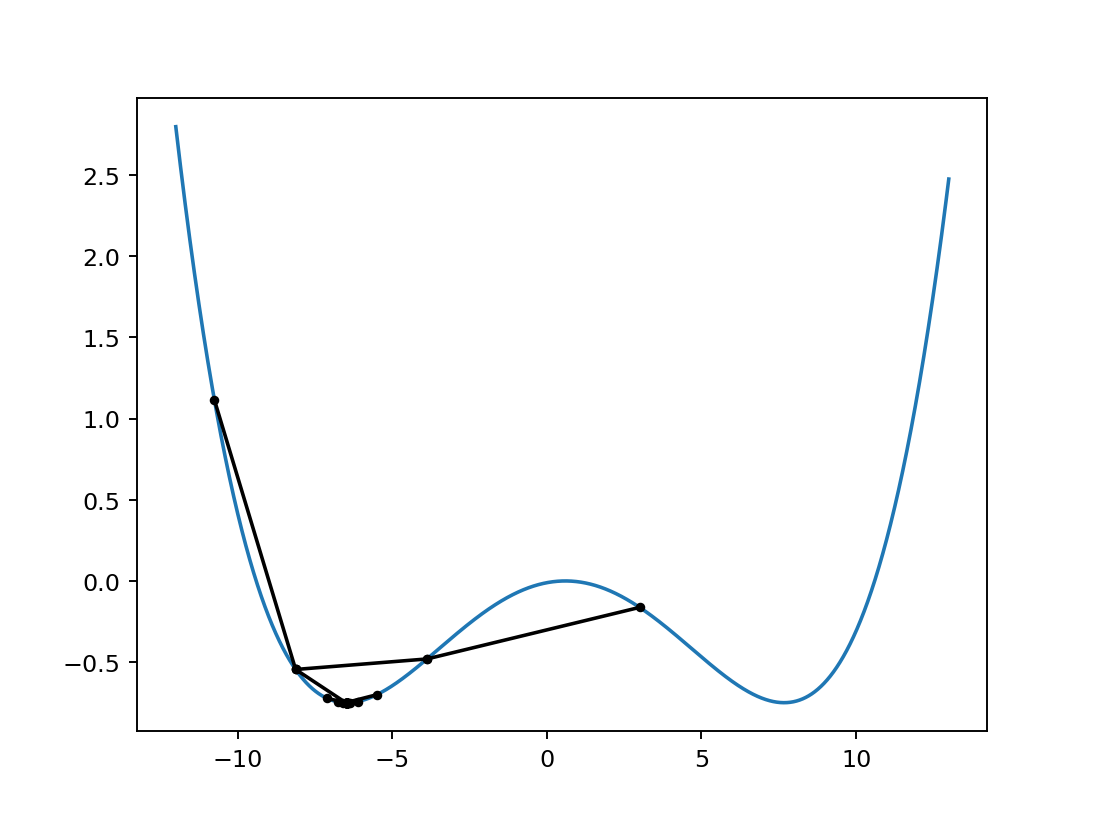

-6.471069263117067


In [18]:
golden(func=func_test2, astart=-15., bstart=3., cstart=14.)

## Multidimensions

In [19]:
xpath = []

def squirrel(xk):
    global xpath
    xpath.append(np.array(xk))

In [21]:
def func2d_quad(x=None, pa=60., ba=0.5, sma=3.):
    """Two-d quadratic
    
    Parameters
    ----------
    
    x : ndarray of np.float64
        x value 
        
    Returns
    -------
    
    val : np.float32
        value of function
"""
    d2r = jnp.pi / 180.
    parad = d2r * pa
    x0p = jnp.cos(parad) * x[..., 0] + jnp.sin(parad) * x[..., 1] 
    x1p = - jnp.sin(parad) * x[..., 0] + jnp.cos(parad) * x[..., 1]
    x1p = x1p / ba
    x0p = x0p / sma 
    x1p = x1p / sma 
    v = 5. + (x0p**2 + x1p**2)
    return(v)
     

In [22]:
def func2d_quad_grad(x=None, pa=60., ba=0.5, sma=3.0):
    """Two-d gaussian gradient
    
    Parameters
    ----------
    
    x : ndarray of np.float64
        x value 
        
    Returns
    -------
    
    grad : ndarray of np.float64
        [2] value of function
"""
    d2r = jnp.pi / 180.
    parad = d2r * pa
    
    x0p = jnp.cos(parad) * x[..., 0] + jnp.sin(parad) * x[..., 1] 
    x1p = - jnp.sin(parad) * x[..., 0] + jnp.cos(parad) * x[..., 1]
    x1p = x1p / ba
    x0p = x0p / sma 
    x1p = x1p / sma 
    
    dx0p = 2. * x0p 
    dx1p = 2. * x1p
    
    dx0p = dx0p / sma
    dx1p = dx1p / (sma * ba)
    
    dx0 = jnp.cos(parad) * dx0p - jnp.sin(parad) * dx1p
    dx1 = jnp.sin(parad) * dx0p + jnp.cos(parad) * dx1p
    
    dx = np.array([dx0, dx1])
    return(dx)
     

In [24]:
func2d_quad_value_and_grad = jax.value_and_grad(func2d_quad, argnums=[0])
xtry = np.array([1., 2.1])
print(func2d_quad_value_and_grad(xtry))
print(func2d_quad(xtry))
print(func2d_quad_grad(xtry))

(Array(5.61239333, dtype=float64), (Array([0.11600444, 0.52799153], dtype=float64),))
5.612393328462004
[0.11600444 0.52799153]


In [25]:
def hessian(f):
  return jax.jacfwd(jax.grad(f))

h = hessian(func2d_quad)
print(h(np.array([0., 0.])))
print(h(np.array([2., 2.])))

[[ 0.72222222 -0.28867513]
 [-0.28867513  0.38888889]]
[[ 0.72222222 -0.28867513]
 [-0.28867513  0.38888889]]


In [26]:
xmin = -5.
xmax = 5.
nx = 100
x0 = xmin + (xmax - xmin) * (0.5 + np.arange(nx, dtype=np.float32)) / np.float32(nx)
x1 = xmin + (xmax - xmin) * (0.5 + np.arange(nx, dtype=np.float32)) / np.float32(nx)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.transpose(np.array([xx0.flatten(), xx1.flatten()]))

In [27]:
v = func2d_quad(x=x)

<IPython.core.display.Javascript object>


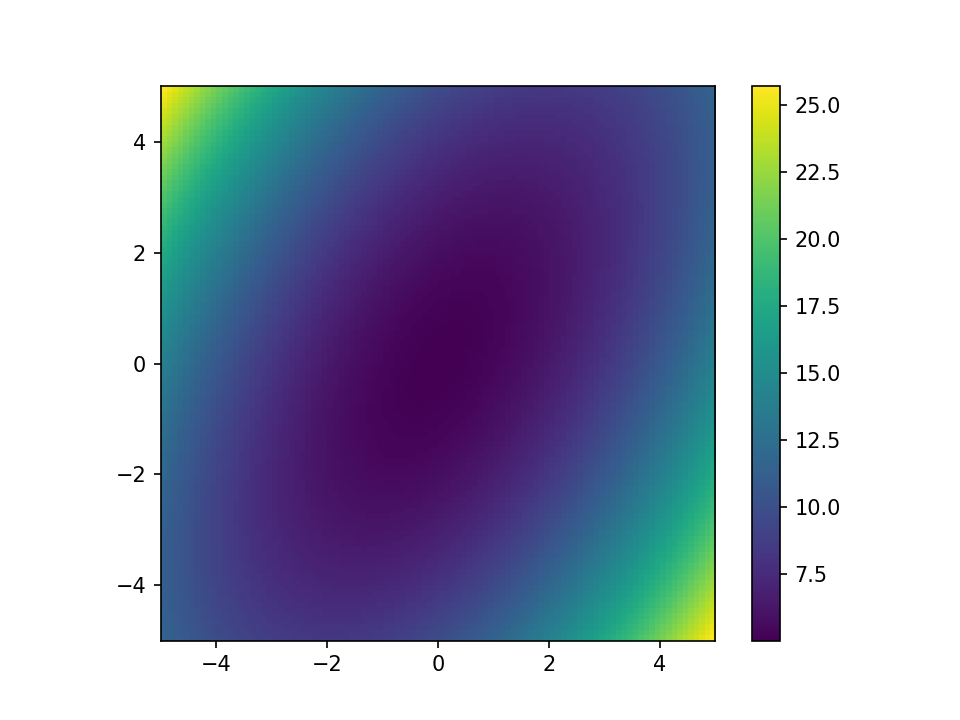

In [28]:
plt.imshow(v.reshape(nx, nx), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.colorbar()

In [29]:
xst = np.array([1., 1.])
xpath = [xst]
r = optimize.minimize(func2d_quad, xst, method='Nelder-Mead', tol=1e-10, callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[-2.46102194e-08 -8.15778289e-09]
Number of function evaluations: 167
Number of iterations: 77


<IPython.core.display.Javascript object>


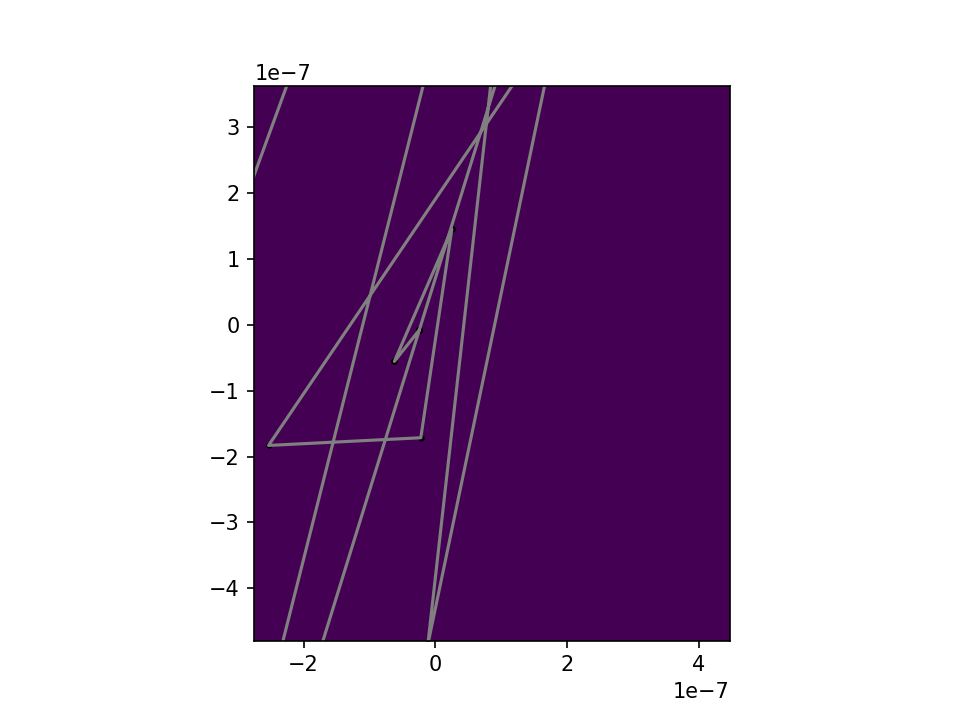

In [31]:
plt.imshow(v.reshape(nx, nx), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.plot(xpath[:, 0], xpath[:, 1], color='grey')
plt.scatter(xpath[:, 0], xpath[:, 1], s=4, color='black')

In [32]:
xst = np.array([1., 3.9])
xpath = [xst]
r = optimize.minimize(func2d_quad, xst, jac=func2d_quad_grad, method='CG', tol=1e-10, callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[-3.77475828e-15 -7.77156117e-15]
Number of function evaluations: 5
Number of iterations: 2


<IPython.core.display.Javascript object>


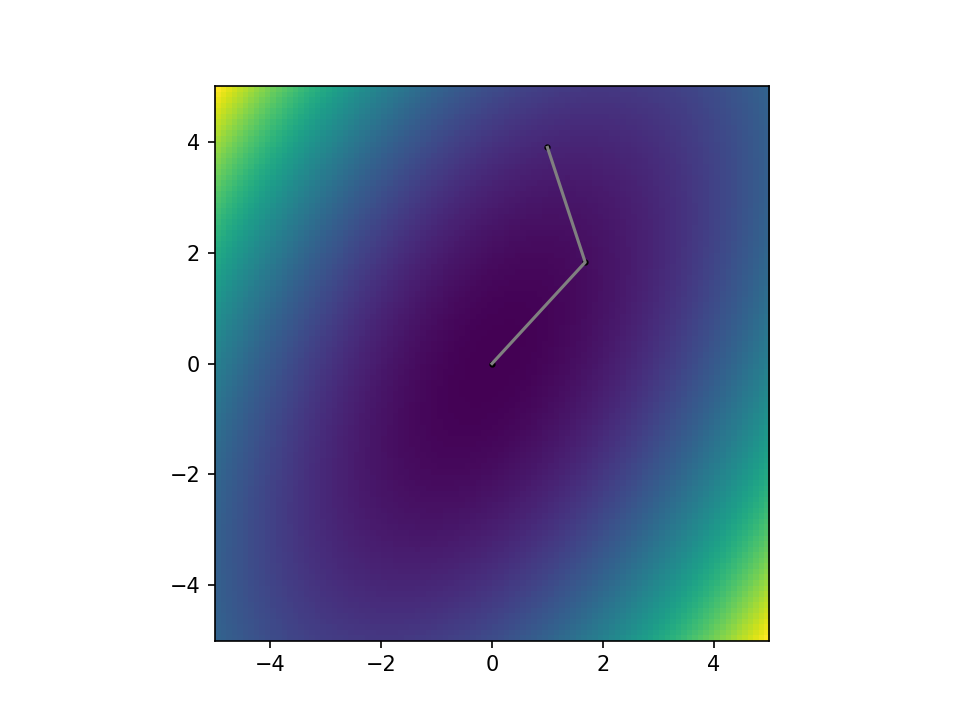

In [33]:
plt.imshow(v.reshape(nx, nx), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.plot(xpath[:, 0], xpath[:, 1], color='grey')
plt.scatter(xpath[:, 0], xpath[:, 1], s=4, color='black')

In [35]:
xst = np.array([1., 4.1])
xpath = [xst]
r = optimize.minimize(func2d_quad, xst, jac=func2d_quad_grad, method='BFGS', tol=1e-10, callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[1.23172631e-11 2.42409012e-11]
Number of function evaluations: 11
Number of iterations: 10


<IPython.core.display.Javascript object>


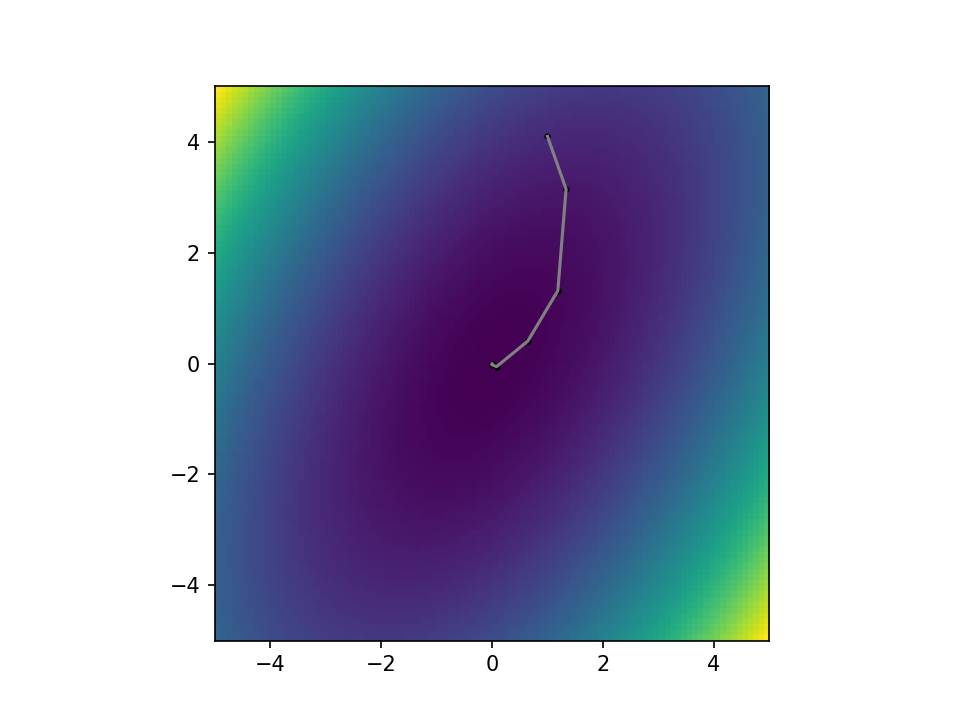

In [36]:
plt.imshow(v.reshape(nx, nx), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.plot(xpath[:, 0], xpath[:, 1], color='grey')
plt.scatter(xpath[:, 0], xpath[:, 1], s=4, color='black')

In [37]:
xst = np.array([1., 4.1])
xpath = [xst]
r = optimize.minimize(func2d_quad_value_and_grad, xst, jac=True, method='L-BFGS-B', tol=1e-10, callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[1.28655193e-07 6.67343614e-08]
Number of function evaluations: 8
Number of iterations: 7


<IPython.core.display.Javascript object>


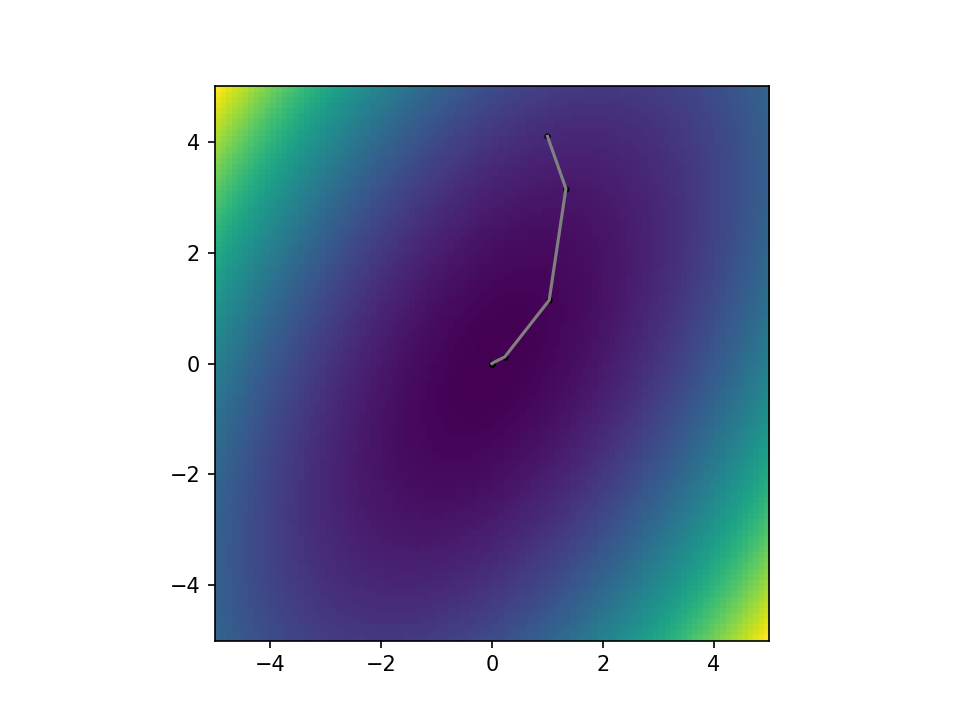

In [38]:
plt.imshow(v.reshape(nx, nx), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.plot(xpath[:, 0], xpath[:, 1], color='grey')
plt.scatter(xpath[:, 0], xpath[:, 1], s=4, color='black')

In [40]:
xst = np.array([1., 4.1])
xpath = [xst]
r = optimize.minimize(func2d_quad, xst, jac=func2d_quad_grad, hess=h, method='Newton-CG',
                      tol=1e-10, callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[0. 0.]
Number of function evaluations: 2
Number of iterations: 2


<IPython.core.display.Javascript object>


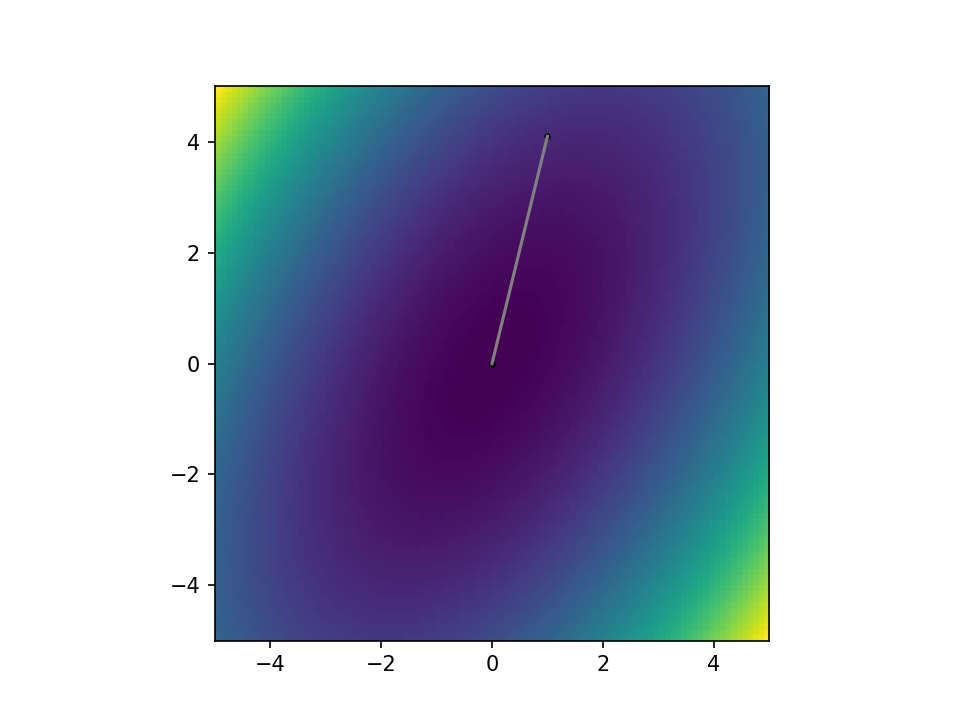

In [41]:
plt.imshow(v.reshape(nx, nx), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.plot(xpath[:, 0], xpath[:, 1], color='grey')
plt.scatter(xpath[:, 0], xpath[:, 1], s=4, color='black')

In [44]:
def func2d(x=None, pa=60., ba=0.4, sma=3.):
    """Two-d gaussian
    
    Parameters
    ----------
    
    x : ndarray of np.float64
        x value 
        
    Returns
    -------
    
    val : np.float32
        value of function
"""
    d2r = jnp.pi / 180.
    parad = d2r * pa
    x0p = jnp.cos(parad) * x[..., 0] + jnp.sin(parad) * x[..., 1] 
    x1p = - jnp.sin(parad) * x[..., 0] + jnp.cos(parad) * x[..., 1]
    x1p = x1p / ba
    x0p = x0p / sma 
    x1p = x1p / sma 
    v = jnp.exp(- 0.5 * (x0p**2 + x1p**2))
    v = v / (2. * jnp.pi * ba * sma**2)
    return( - v)
     

In [45]:
def func2d_grad(x=None, pa=60., ba=0.4, sma=3.0):
    """Two-d gaussian gradient
    
    Parameters
    ----------
    
    x : ndarray of np.float64
        x value 
        
    Returns
    -------
    
    grad : ndarray of np.float64
        [2] value of function
"""
    d2r = jnp.pi / 180.
    parad = d2r * pa
    
    x0p = jnp.cos(parad) * x[..., 0] + jnp.sin(parad) * x[..., 1] 
    x1p = - jnp.sin(parad) * x[..., 0] + jnp.cos(parad) * x[..., 1]
    x1p = x1p / ba
    x0p = x0p / sma 
    x1p = x1p / sma 
    
    v = jnp.exp(- 0.5 * (x0p**2 + x1p**2))
    v = v / (2. * jnp.pi * sma**2)
    
    dx0p = x0p * v
    dx1p = x1p * v
    
    dx0p = dx0p / sma
    dx1p = dx1p / (sma * ba)
    
    dx0 = jnp.cos(parad) * dx0p - jnp.sin(parad) * dx1p
    dx1 = jnp.sin(parad) * dx0p + jnp.cos(parad) * dx1p
    
    dx = np.array([dx0, dx1]) / ba
    return(dx)
     

In [46]:
func2d_jax_grad_scalar = jax.grad(func2d, argnums=[0])
def func2d_jax_grad(x):
    if(len(x.shape) > 1):
        return(np.array([func2d_jax_grad_scalar(xt) for xt in x]))
    else:
        return(np.squeeze(np.array(func2d_jax_grad_scalar(x))))

In [47]:
func2d_value_and_grad = jax.value_and_grad(func2d, argnums=[0])
xtry = np.array([1., 2.1])
print(func2d_value_and_grad(xtry))
print(func2d(xtry))
print(func2d_grad(xtry))
print(func2d_jax_grad(xtry))

(Array(-0.03241162, dtype=float64), (Array([0.00058894, 0.00930189], dtype=float64),))
-0.03241161581553725
[0.00058894 0.00930189]
[0.00058894 0.00930189]


In [48]:
xmin = -5.
xmax = 5.
nx = 100
x0 = xmin + (xmax - xmin) * (0.5 + np.arange(nx, dtype=np.float32)) / np.float32(nx)
x1 = xmin + (xmax - xmin) * (0.5 + np.arange(nx, dtype=np.float32)) / np.float32(nx)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.transpose(np.array([xx0.flatten(), xx1.flatten()]))

In [49]:
v = func2d(x=x)

<IPython.core.display.Javascript object>


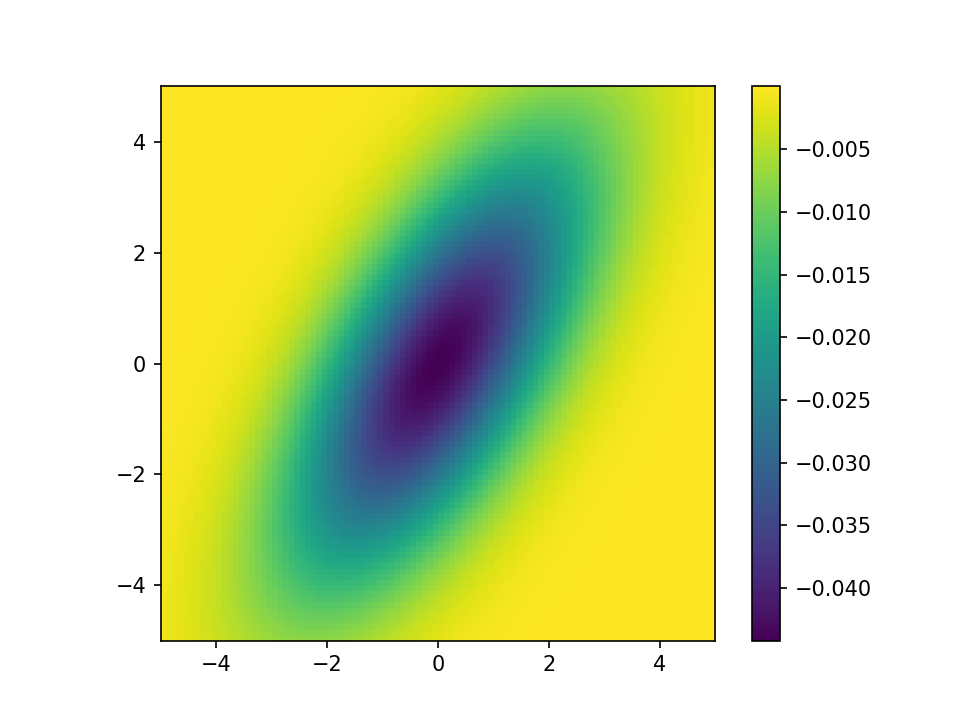

In [51]:
plt.imshow(v.reshape(nx, nx), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.colorbar()

In [45]:
xst = np.array([1., 1.])
xpath = [xst]
r = optimize.minimize(func2d, xst, method='Nelder-Mead', tol=1e-10, callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[ 5.08528176e-09 -6.09770891e-09]
Number of function evaluations: 162
Number of iterations: 74


<IPython.core.display.Javascript object>


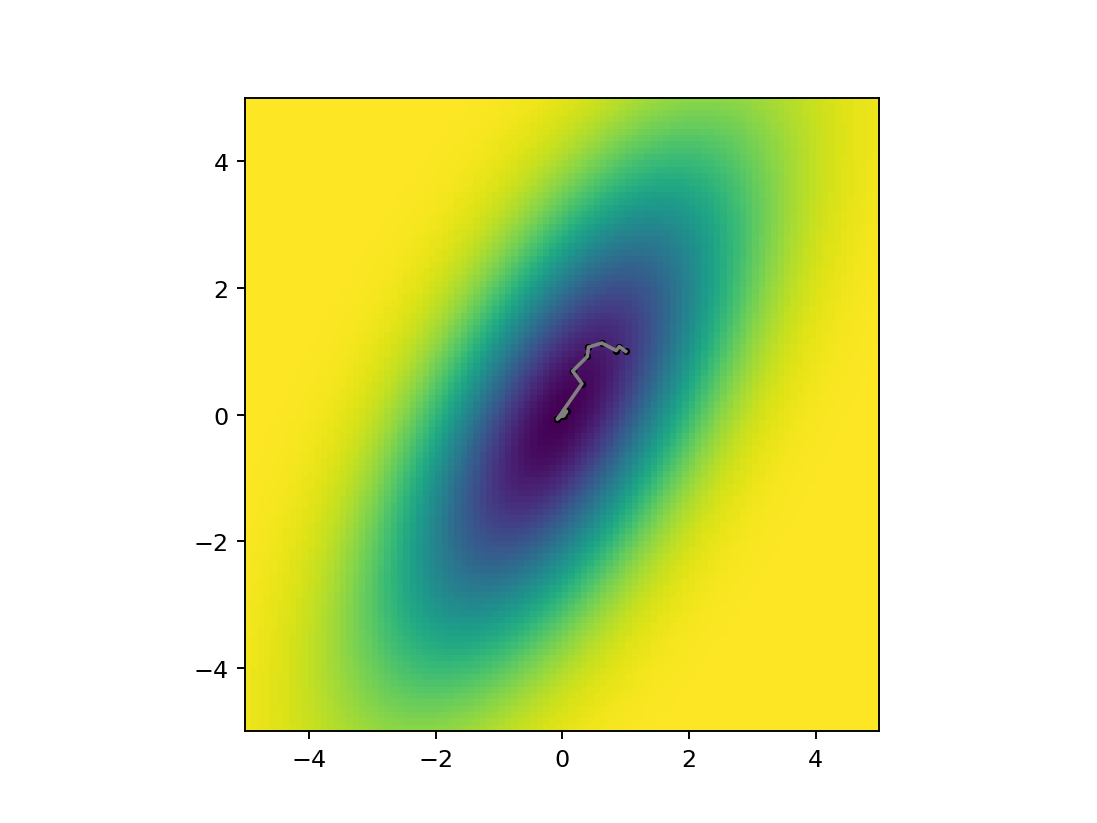

In [46]:
plt.imshow(v.reshape(nx, nx), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.plot(xpath[:, 0], xpath[:, 1], color='grey')
plt.scatter(xpath[:, 0], xpath[:, 1], s=4, color='black')

In [47]:
xst = np.array([1., 3.9])
xpath = [xst]
r = optimize.minimize(func2d, xst, jac=func2d_grad, method='CG', tol=1e-10, callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[-3.16780907e-10 -2.05117997e-12]
Number of function evaluations: 60
Number of iterations: 15


<IPython.core.display.Javascript object>


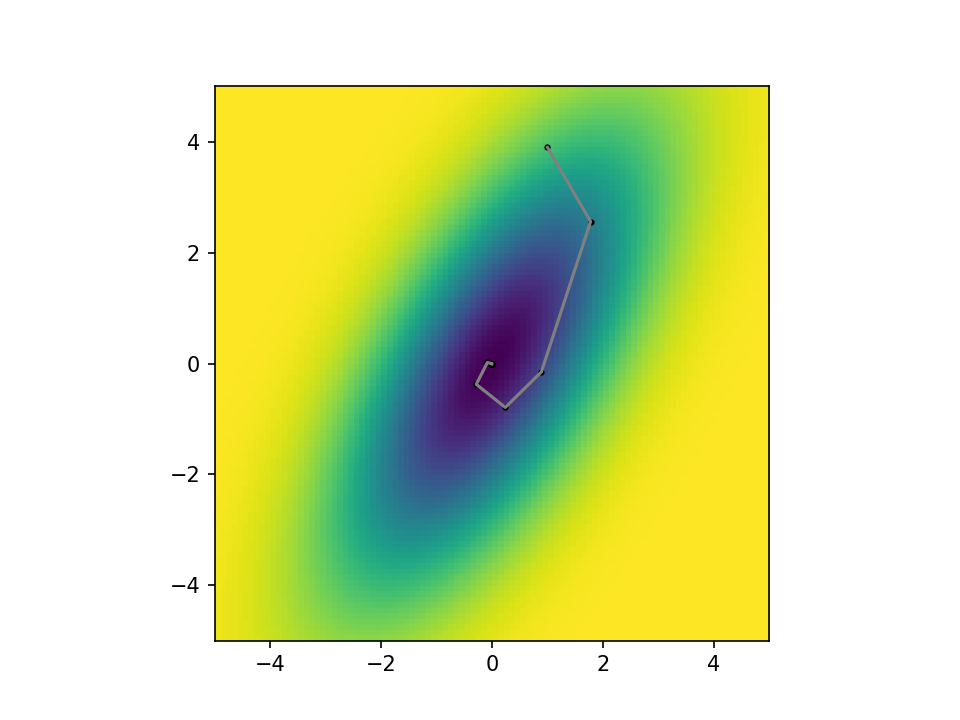

In [145]:
plt.imshow(v.reshape(nx, nx), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.plot(xpath[:, 0], xpath[:, 1], color='grey')
plt.scatter(xpath[:, 0], xpath[:, 1], s=4, color='black')

In [52]:
xst = np.array([1., 4.1])
xpath = [xst]
r = optimize.minimize(func2d, xst, jac=func2d_grad, method='BFGS', tol=1e-10, callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[-7.68585516e-11 -4.34257285e-11]
Number of function evaluations: 22
Number of iterations: 17


<IPython.core.display.Javascript object>


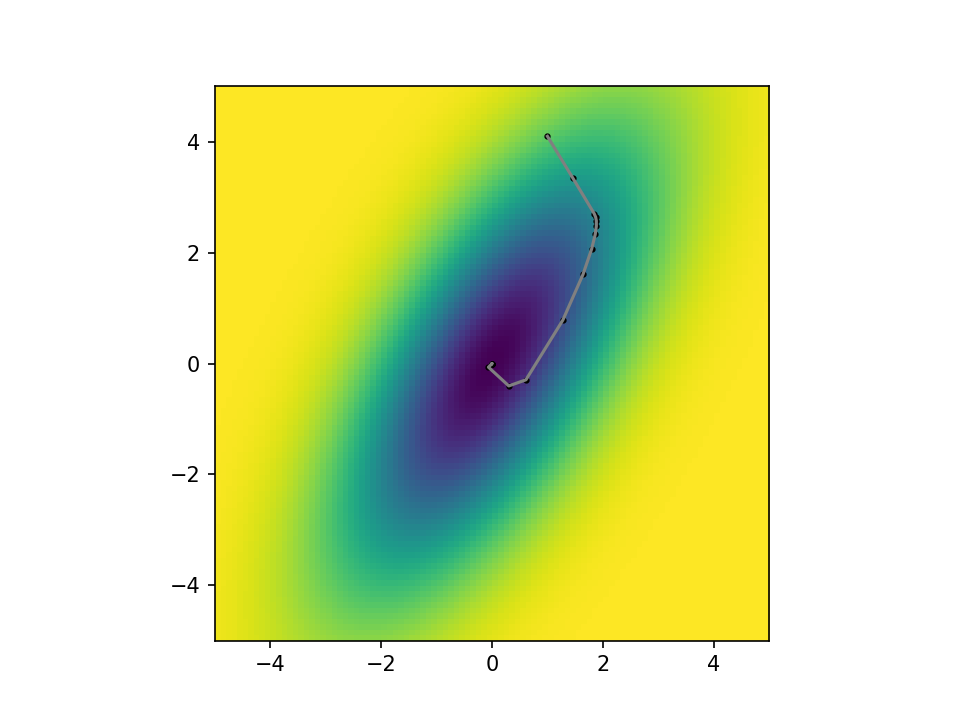

In [53]:
plt.imshow(v.reshape(nx, nx), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.plot(xpath[:, 0], xpath[:, 1], color='grey')
plt.scatter(xpath[:, 0], xpath[:, 1], s=4, color='black')

In [54]:
xst = np.array([1., 4.1])
r = optimize.minimize(func2d, xst, jac=func2d_jax_grad, method='BFGS', tol=1e-10)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[-7.68585516e-11 -4.34257285e-11]
Number of function evaluations: 22
Number of iterations: 17


In [55]:
xst = np.array([1., 4.1])
r = optimize.minimize(func2d_value_and_grad, xst, jac=True, method='L-BFGS-B', tol=1e-10)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[2.44795526e-06 6.38862353e-06]
Number of function evaluations: 12
Number of iterations: 10


In [56]:
def func2d_rosenbrock(x=None, a=1., b=100):
    """Two-d Rosenbrock
    
    Parameters
    ----------
    
    x : ndarray 
        [2] or [2, N] array of coords
        
    Returns
    -------
    
    val : np.float32
        value of function
        
    Comments
    --------
    
    Global minimum is at (a, a**2)
"""
    v = (a - x[..., 0])**2 + b * (x[..., 1] - x[..., 0]**2)**2
    return(v)
     

In [57]:
def func2d_rosenbrock_grad(x=None, a=1., b=100):
    """Two-d Rosenbrock gradient
    
    Parameters
    ----------
    
    x : ndarray 
        [2] array of coords
        
    Returns
    -------
    
    grad : np.float32
        [2] array of gradient 
"""
    dx0 = - 2 * (a - x[..., 0]) - 4. * b * (x[..., 1] - x[..., 0]**2) * x[..., 0]
    dx1 = 2 * b * (x[..., 1] - x[..., 0]**2)
    grad = np.array([dx0, dx1])
    return(grad)
     

In [58]:
func2d_rosenbrock_value_and_grad = jax.value_and_grad(func2d_rosenbrock, argnums=[0])
xtry = np.array([1., 2.1])
print(func2d_rosenbrock_value_and_grad(xtry))
print(func2d_rosenbrock(xtry))
print(func2d_rosenbrock_grad(xtry))

(Array(121., dtype=float64), (Array([-440.,  220.], dtype=float64),))
121.00000000000001
[-440.  220.]


In [59]:
xmin = -4.
xmax = 4.
nx = 100
x0 = xmin + (xmax - xmin) * (0.5 + np.arange(nx, dtype=np.float32)) / np.float32(nx)
x1 = xmin + (xmax - xmin) * (0.5 + np.arange(nx, dtype=np.float32)) / np.float32(nx)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.transpose(np.array([xx0.flatten(), xx1.flatten()]))

In [60]:
v = func2d_rosenbrock(x=x)

<IPython.core.display.Javascript object>


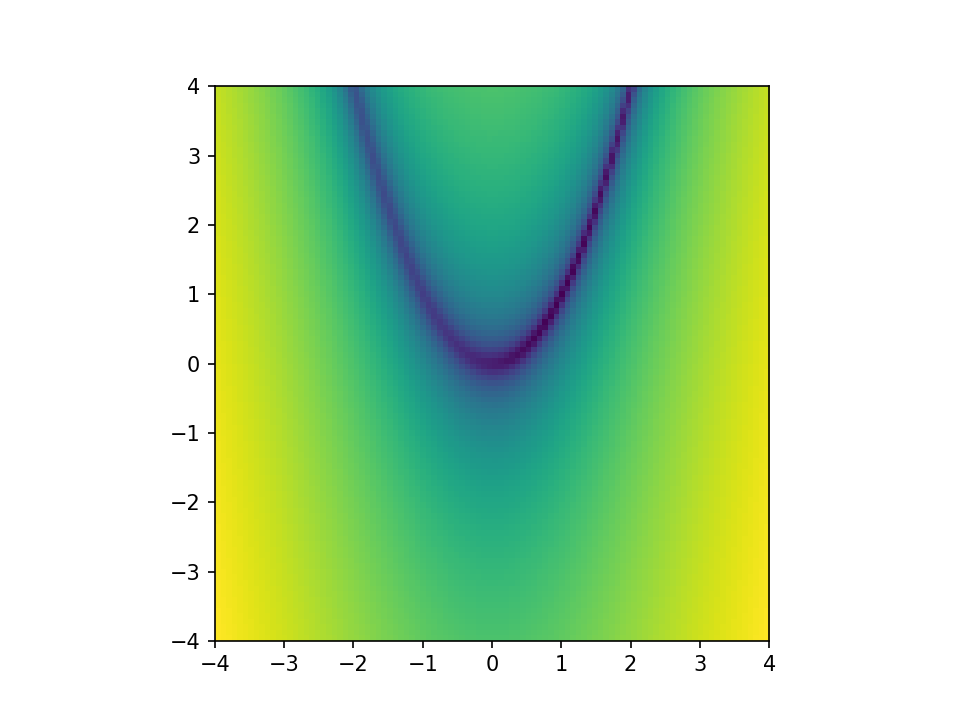

In [61]:
plt.imshow(np.arcsinh(v.reshape(nx, nx)), origin='lower', extent=[xmin, xmax, xmin, xmax])

In [62]:
xst = np.array([1., 3.9])
xpath = [xst]
r = optimize.minimize(func2d_rosenbrock, xst, method='Nelder-Mead', tol=1e-10, callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[1. 1.]
Number of function evaluations: 198
Number of iterations: 101


<IPython.core.display.Javascript object>


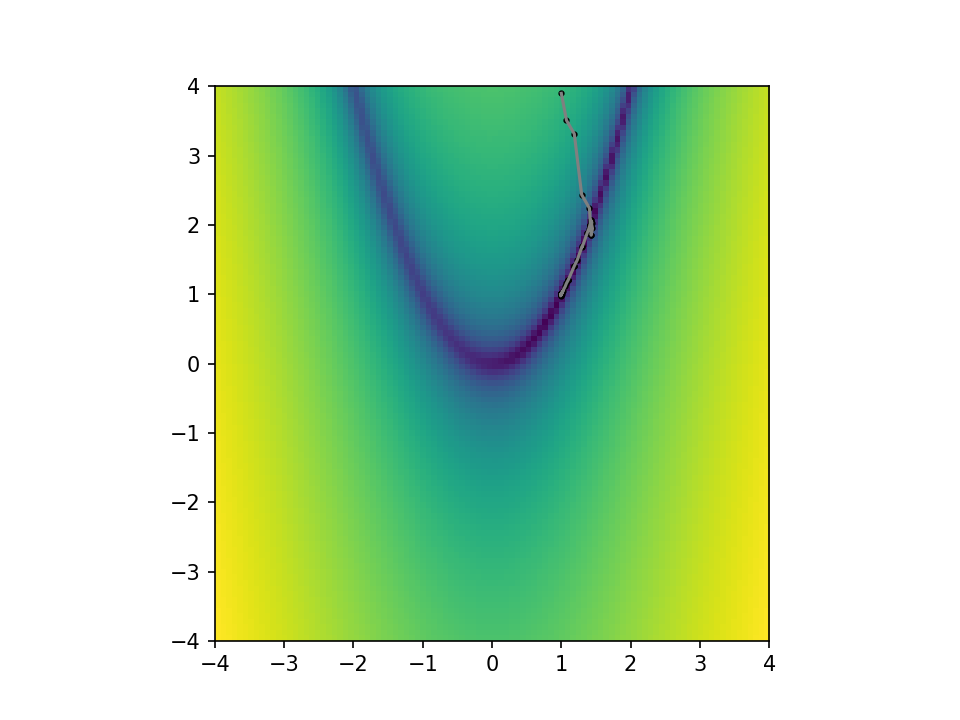

In [63]:
plt.imshow(np.arcsinh(v.reshape(nx, nx)), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.plot(xpath[:, 0], xpath[:, 1], color='grey')
plt.scatter(xpath[:, 0], xpath[:, 1], s=4, color='black')

In [64]:
xst = np.array([1., 3.9])
xpath = [xst]
r = optimize.minimize(func2d_rosenbrock, xst, jac=func2d_rosenbrock_grad, method='CG', tol=1e-10,
                      callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[1. 1.]
Number of function evaluations: 136
Number of iterations: 42


<IPython.core.display.Javascript object>


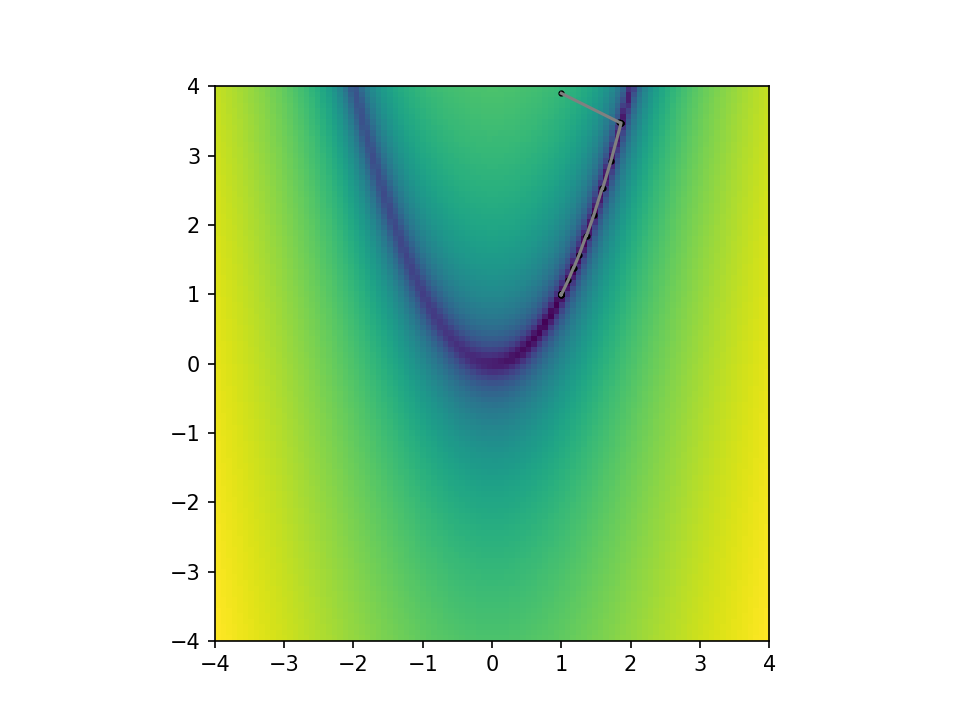

In [65]:
plt.imshow(np.arcsinh(v.reshape(nx, nx)), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.plot(xpath[:, 0], xpath[:, 1], color='grey')
plt.scatter(xpath[:, 0], xpath[:, 1], s=4, color='black')

In [66]:
xst = np.array([1., 3.9])
xpath = [xst]
r = optimize.minimize(func2d_rosenbrock, xst, jac=func2d_rosenbrock_grad, method='BFGS', tol=1e-10,
                      callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[1. 1.]
Number of function evaluations: 36
Number of iterations: 28


<IPython.core.display.Javascript object>


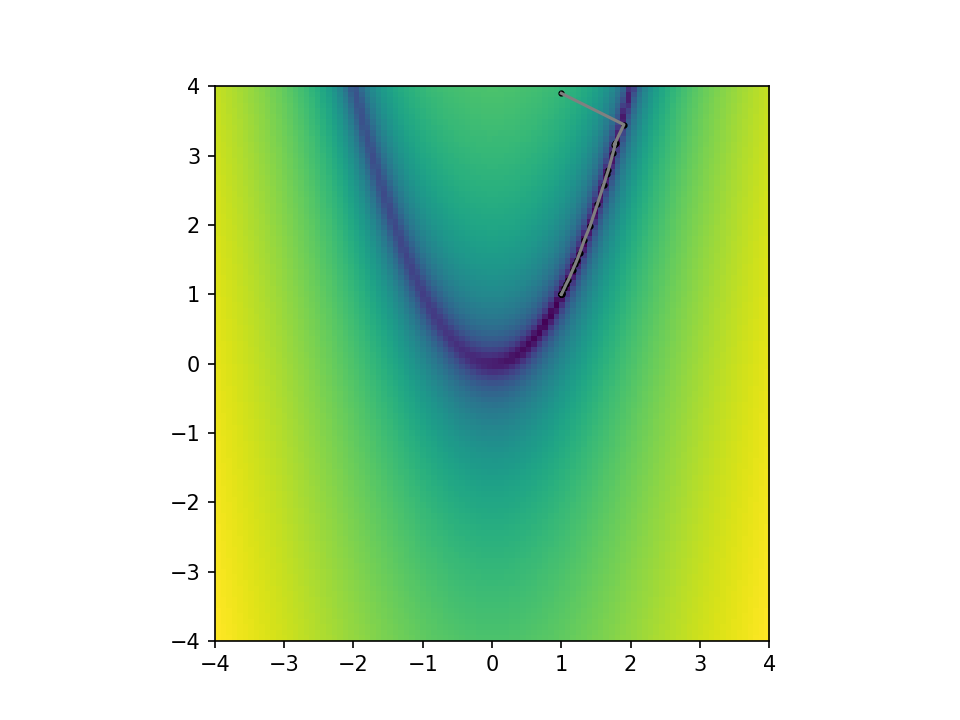

In [67]:
plt.imshow(np.arcsinh(v.reshape(nx, nx)), origin='lower', extent=[xmin, xmax, xmin, xmax])
plt.plot(xpath[:, 0], xpath[:, 1], color='grey')
plt.scatter(xpath[:, 0], xpath[:, 1], s=4, color='black')

A warning about checking that your library is working! Rosenbrock is a standard case, it is appalling that Jax would have an implementation of BFGS that fails in this case.

In [68]:
xst = jnp.array([1., 3.9], dtype=np.float64)
r = jax.scipy.optimize.minimize(func2d_rosenbrock, xst, method='BFGS', tol=1e-10)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))
print(r)

[1.15786729 1.33722412]
Number of function evaluations: 24
Number of iterations: 16
OptimizeResults(x=Array([1.15786729, 1.33722412], dtype=float64), success=Array(False, dtype=bool), status=Array(3, dtype=int64, weak_type=True), fun=Array(0.02610031, dtype=float64), jac=Array([ 1.90550349, -0.6865074 ], dtype=float64), hess_inv=Array([[0.31398689, 0.76697582],
       [0.76697582, 1.87647655]], dtype=float64), nfev=Array(24, dtype=int64, weak_type=True), njev=Array(24, dtype=int64, weak_type=True), nit=Array(16, dtype=int64, weak_type=True))


Note that "recommended" alternative jaxopt also has a broken BFGS implementation. The LBFGS implementation is better. But note that I still had to monkey with step sizes, and it didn't even always work in that case.

## Optimization application

Let's perform a nonlinear optimization with this technique. For this purpose we are just going to do something simple, which is to fit the following model with free parameters $a$ and $r$ to some noisy data:

$$
m(x) = \left[\left(1 + a x^2\right) \exp\left(- \frac{x}{r} - \frac{x^2}{q}\right)\right]
$$

The data will be from this model, with Gaussian noise added.

<IPython.core.display.Javascript object>


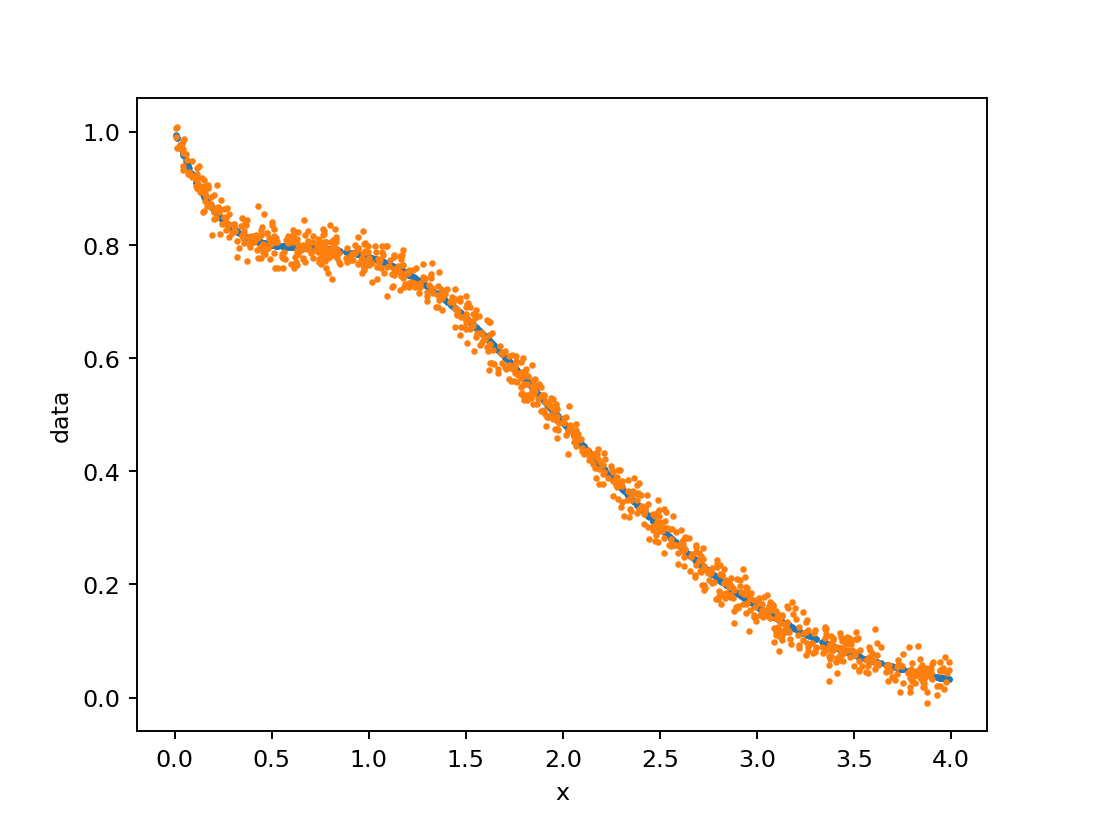

Text(0, 0.5, 'data')

In [69]:
def model(x, params=[1.5, 1., 6.]):
    a = params[0]
    r = params[1]
    q = params[2]
    m = ((1. + a * x**2) * jnp.exp(- x / r - x**2 / q))
    return(m)

ndata = 1000
x = np.random.random(ndata) * 4.
m = model(x)

sigma = 2.e-2
dsim = m + np.random.normal(size=ndata) * sigma

plt.scatter(x, m, s=3)
plt.scatter(x, dsim, s=3)
plt.xlabel('x')
plt.ylabel('data')

In this case, we can write down the likelihood of a data $d_i(x_i)$ under the model, if the noise is known:

$$p_i = \frac{1}{\sqrt{2\pi} \sigma} 
\exp\left[- \frac{\left(d_i - m(x_i | a, q, r)\right)^2}{2\sigma^2}\right]$$

The likelihood of the full data set, if all of the noise is independently distributed is:

$$L = \prod_i p_i$$

The likelihood is a very high dynamic range number! If there are 1000 data points, and the typical residual with respect to the model is $1\sigma$, then the likelihood is $L\sim \exp(-500)$, which cannot be represented at double precision. And small changes to the model will lead to large likelihood changes.

So we almost always instead minimize the negative log likelihood:

$$- \ln L = - \sum_i \ln p_i$$

Note that in the case of Gaussian distributed errors, the residual is:

$$ - \ln L = \frac{1}{2} \sum_i \frac{\left(d_i - m(x_i | a, q, r)\right)^2}{\sigma^2} + \mathrm{~constant}$$

which we could write as $\chi^2 = - 2 \ln L$ (though remember this quantity is *only* $\chi^2$-distributed if $m$ is linear in its parameters).

Regardless, now we know what function to minimize!

In [73]:
def negloglike(params, *args):
    sigma = args[0]
    x = args[1]
    data = args[2]
    m = model(x, params=params)
    lnpi = 0.5 * (data - m)**2 / sigma**2
    nll = lnpi.sum()
    return(nll)

In [74]:
negloglike_grad = jax.grad(negloglike)

In [71]:
pst = np.array([2., 2., 2.])
xpath = [pst]
r = optimize.minimize(negloglike, pst, args=(sigma, x, dsim), method='Nelder-Mead', tol=1e-6, callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[1.43019809 1.03451958 5.76204141]
Number of function evaluations: 319
Number of iterations: 182


In [75]:
pst = np.array([2., 2., 2.])
xpath = [pst]
r = optimize.minimize(negloglike, pst, jac=negloglike_grad,
                      args=(sigma, x, dsim), method='CG', tol=1e-6, callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[1.43019809 1.03451961 5.76204093]
Number of function evaluations: 208
Number of iterations: 66


In [76]:
pst = np.array([2., 2., 2.])
xpath = [pst]
r = optimize.minimize(negloglike, pst, jac=negloglike_grad,
                      args=(sigma, x, dsim), method='BFGS', tol=1e-6, callback=squirrel)
xpath = np.array(xpath)
print(r.x)
print("Number of function evaluations: {n}".format(n=r.nfev))
print("Number of iterations: {n}".format(n=r.nit))

[1.43019812 1.03451959 5.76204102]
Number of function evaluations: 60
Number of iterations: 48


What is the error in this fit? Well ... this takes a bit more doing. You need to look at the curvature of the likelihood function in the three parameters, which in the linear case is related to the covariance matrix of the parameters. Specifically the Hessian is the inverse of the covariance matrix.

In the nonlinear case you can use the Hessian of the log likelihood at the minimum as an estimate, but this is only correct asymptotically for large data sets. If the cubic and higher order components are important within a couple of sigma of the right answer, this won't work well. You can test this by raising sigma in this notebook.

This consideration is what drives people to Markov Chain Monte Carlo.

In [77]:
def hessian(f):
  return jax.jacfwd(jax.grad(f))

h = hessian(negloglike)

In [80]:
hmat = np.array(h(r.x, sigma, x, dsim))
covar = np.linalg.inv(hmat)
print(covar)
print(np.sqrt(np.diag(covar)))

[[ 0.00157018 -0.00079536  0.00442676]
 [-0.00079536  0.00041098 -0.00236417]
 [ 0.00442676 -0.00236417  0.01458151]]
[0.03962545 0.0202726  0.12075392]


In [81]:
sigma2 = np.diag(covar)
corr = covar
for i in np.arange(3):
    for j in np.arange(3):
        corr[i, j] = covar[i, j] / np.sqrt(sigma2[i] * sigma2[j])
print(corr)

[[ 1.         -0.03923311  0.03665936]
 [-0.03923311  1.         -0.01957843]
 [ 0.03665936 -0.01957843  1.        ]]


Great, but I want to point out one more thing. Parts of this fit can be done linearly. At a given $q$ and $r$, the model is linear in $a$ with Gaussian errors. This allows the minimization on $a$ to be done just by minimizing:

$$ - \ln L = \frac{1}{2} \sum_i \frac{\left(d_i - (1 + a x_i^2) m(x_i | a=0, q, r)\right)^2}{\sigma^2}$$

and rearranging a bit:

$$ - \ln L = \frac{1}{2} \sum_i \frac{\left((d_i - m_i) - a x_i^2 m_i\right)^2}{\sigma^2}$$

and then finding:

$$\frac{\partial \ln L}{\partial a} = 0 = 
\frac{1}{2} \sum_i \frac{\left((d_i - m_i) - a x_i^2 m_i\right) x_i^2 m_i}{\sigma^2}$$

we can solve for:

$$a= \frac{\sum_i (d_i - m_i)x_i^2 m_i}{\sum_i x_i^4 m_i^2}$$

Note that you can play this game with any number of linear parameters, this is just inverting the $1\times 1$ matrix you need to invert when there is just one linear parameter.

In [82]:
def fit_a(q=None, r=None, x=None, data=None):
    p = [0., r, q] 
    m = model(x, params=p)
    a = ((data - m) * x**2 * m).sum () / (x**4 * m**2).sum()
    return(a)
    
def negloglike_2(params, *args):
    sigma = args[0]
    x = args[1]
    data = args[2]
    r = params[0]
    q = params[1]
    a = fit_a(q=q, r=r, x=x, data=data)
    params3 = [a, r, q]
    m = model(x, params=params3)
    lnpi = 0.5 * (data - m)**2 / sigma**2
    nll = lnpi.sum()
    return(nll)

negloglike_2_grad = jax.grad(negloglike_2)

In [83]:
pst2 = np.array([2., 2.])
xpath = [pst2]
res = optimize.minimize(negloglike_2, pst2, jac=negloglike_2_grad,
                      args=(sigma, x, dsim), method='BFGS', tol=1e-6, callback=squirrel)
xpath = np.array(xpath)
r = res.x[0]
q = res.x[1]
a = fit_a(x=x, data=dsim, r=r, q=q)
print(np.array([a, r, q]))

print("Number of function evaluations: {n}".format(n=res.nfev))
print("Number of iterations: {n}".format(n=res.nit))

[1.43019812 1.03451959 5.76204102]
Number of function evaluations: 33
Number of iterations: 22
